In [5]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [6]:
# runtime imports
# from qiskit_ibm_runtime import QiskitRuntimeService, Session
# # To run on hardware, select the backend with the fewest number of jobs in the queue
# service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(operational=True, simulator=False)

In [7]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import QasmSimulator, AerSimulator

from qiskit_algorithms.optimizers import ADAM

backend = QasmSimulator()

In [8]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

In [9]:
ansatz = EfficientSU2(hamiltonian.num_qubits)

In [10]:
num_params = ansatz.num_parameters

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [11]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [14]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [15]:
x0 = 2 * np.pi * np.random.random(num_params)

In [18]:
with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 10000

    res = ADAM.minimize(
        fun=cost_func,
        x0=x0
    )

/home/azhar04/.local/lib/python3.10/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


TypeError: ADAM.minimize() missing 1 required positional argument: 'self'

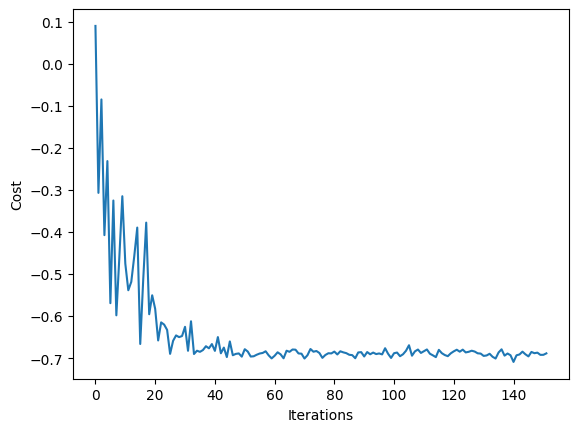

In [13]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()